In [1]:
#movie recommendation system code - in progress. updates coming soon

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
#read in csv files
df1 = pd.read_csv('/Users/vaidehikarve/git_movie_recommender_project/movie-recommender/csv_db/tmdb_5000_movies.csv')
df2 = pd.read_csv('/Users/vaidehikarve/git_movie_recommender_project/movie-recommender/csv_db/tmdb_5000_credits.csv')

In [4]:
#merge the two dataframes
print(df1.columns)
print(df2.columns)

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')
Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')


In [5]:
#since the two dataframes have different column names, we need to rename the column in df2 to match the column in df1
df2 = df2.rename(columns = {'movie_id' : 'id'})
df1 = df1.merge(df2, on = 'id')
movies = df1
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')

In [6]:
movies = movies.drop(['title_x'], axis= 1)

In [7]:
movies = movies.rename(columns = {'title_y' : 'title'})
movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,title,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]",...,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",6.6,238,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],...,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,5.9,5,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_.

In [8]:
'''demographic filtering. since we are not using any user demographic information for recommendations, we need to come up with a generic metric to rate movies by. we will use IMDB's weighted rating formula to construct our chart.
the formula is weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C where:
'''
# r = average vote for the movie (vote_average)
# v = number of votes for the movie (vote_count)
# m = minimum votes required to be listed
# C = the mean vote across the whole report

c = movies['vote_average'].mean()
print(c)

#determine a cutoff value for the minimum number of votes required, for m, filter out dataset to only contain movies with >= m votes. we want the top 10% of movies
m = movies['vote_count'].quantile(0.9)
print(m)

6.092171559442016
1838.4000000000015


In [9]:
#create a function that returns this tmdb weighted rating
def weighted_rating(series_data, m = m, c = c):
    v = series_data['vote_count']
    r = series_data['vote_average']
    return (v/(v+m) * r) + (m/(m+v) * c)

In [10]:
#apply it to the df, add "weighted score" as column and sort it by new column
top_movies = movies.copy()
w_score = top_movies.apply(weighted_rating, axis = 1)
top_movies['w_score'] = w_score
top_movies = top_movies.sort_values(by = 'w_score', ascending = False)
top_movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,title,cast,crew,w_score
1881,25000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",NaN,278,"[{""id"": 378, ""name"": ""prison""}, {""id"": 417, ""n...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,136.747729,"[{""name"": ""Castle Rock Entertainment"", ""id"": 97}]",...,142.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Fear can hold you prisoner. Hope can set you f...,8.5,8205,The Shawshank Redemption,"[{""cast_id"": 3, ""character"": ""Andy Dufresne"", ...","[{""credit_id"": ""52fe4231c3a36847f800b153"", ""de...",8.059258
662,63000000,"[{""id"": 18, ""name"": ""Drama""}]",http://www.foxmovies.com/movies/fight-club,550,"[{""id"": 825, ""name"": ""support group""}, {""id"": ...",en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,146.757391,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...",...,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Mischief. Mayhem. Soap.,8.3,9413,Fight Club,"[{""cast_id"": 4, ""character"": ""The Narrator"", ""...","[{""credit_id"": ""55731b8192514111610027d7"", ""de...",7.939256
65,185000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",http://thedarkknight.warnerbros.com/dvdsite/,155,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...",...,152.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Why So Serious?,8.2,12002,The Dark Knight,"[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de...",7.920020
3232,8000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 80, ""n...",NaN,680,"[{""id"": 396, ""name"": ""transporter""}, {""id"": 14...",en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",121.463076,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...",...,154.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Just because you are a character doesn't mean ...,8.3,8428,Pulp Fiction,"[{""cast_id"": 2, ""character"": ""Vincent Vega"", ""...","[{""credit_id"": ""52fe4269c3a36847f801caa3"", ""de...",7.904645
96,160000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://inceptionmovie.warnerbros.com/,27205,"[{""id"": 1014, ""name"": ""loss of lover""}, {""id"":...",en,Inception,"Cobb, a skilled thief who commits corporate es...",167.583710,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,148.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Your mind is the scene of the crime.,8.1,13752,Inception,"[{""cast_id"": 1, ""character"": ""Dom Cobb"", ""cred...","[{""credit_id"": ""56e8462cc3a368408400354c"", ""de...",7.863239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,100000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,14164,"[{""id"": 3436, ""name"": ""karate""}, {""id"": 9715, ...",en,Dragonball Evolution,The young warrior Son Goku sets out on a quest...,21.677732,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,85.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The legend comes to life.,2.9,462,Dragonball Evolution,"[{""cast_id"": 17, ""character"": ""Master Roshi"", ...","[{""credit_id"": ""52fe45d29251416c75063b05"", ""de...",5.451073
91,165000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.warof1996.com,47933,"[{""id"": 12026, ""name"": ""alternate history""}, {...",en,Independence Day: Resurgence,We always knew they were coming back. Using re...,48.775723,"[{""name"": ""Twentieth Century Fox Film Corporat...",...,120.0,"[{""iso_639_1"": ""en"", ""name"": ""Eng

In [11]:
#filter out movies with minimum votes < m (as calculated earlier)
top_movies = top_movies[top_movies['vote_count'] > m]
top_movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,title,cast,crew,w_score
1881,25000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",NaN,278,"[{""id"": 378, ""name"": ""prison""}, {""id"": 417, ""n...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,136.747729,"[{""name"": ""Castle Rock Entertainment"", ""id"": 97}]",...,142.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Fear can hold you prisoner. Hope can set you f...,8.5,8205,The Shawshank Redemption,"[{""cast_id"": 3, ""character"": ""Andy Dufresne"", ...","[{""credit_id"": ""52fe4231c3a36847f800b153"", ""de...",8.059258
662,63000000,"[{""id"": 18, ""name"": ""Drama""}]",http://www.foxmovies.com/movies/fight-club,550,"[{""id"": 825, ""name"": ""support group""}, {""id"": ...",en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,146.757391,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...",...,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Mischief. Mayhem. Soap.,8.3,9413,Fight Club,"[{""cast_id"": 4, ""character"": ""The Narrator"", ""...","[{""credit_id"": ""55731b8192514111610027d7"", ""de...",7.939256
65,185000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",http://thedarkknight.warnerbros.com/dvdsite/,155,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...",...,152.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Why So Serious?,8.2,12002,The Dark Knight,"[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de...",7.920020
3232,8000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 80, ""n...",NaN,680,"[{""id"": 396, ""name"": ""transporter""}, {""id"": 14...",en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",121.463076,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...",...,154.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Just because you are a character doesn't mean ...,8.3,8428,Pulp Fiction,"[{""cast_id"": 2, ""character"": ""Vincent Vega"", ""...","[{""credit_id"": ""52fe4269c3a36847f801caa3"", ""de...",7.904645
96,160000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://inceptionmovie.warnerbros.com/,27205,"[{""id"": 1014, ""name"": ""loss of lover""}, {""id"":...",en,Inception,"Cobb, a skilled thief who commits corporate es...",167.583710,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,148.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Your mind is the scene of the crime.,8.1,13752,Inception,"[{""cast_id"": 1, ""character"": ""Dom Cobb"", ""cred...","[{""credit_id"": ""56e8462cc3a368408400354c"", ""de...",7.863239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,200000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",http://greenlanternmovie.warnerbros.com/,44912,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 4375...",en,Green Lantern,"For centuries, a small but powerful force of w...",51.872839,"[{""name"": ""De Line Pictures"", ""id"": 2609}, {""n...",...,114.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"In our darkest hour, there will be light.",5.1,2487,Green Lantern,"[{""cast_id"": 6, ""character"": ""Hal Jordan / Gre...","[{""credit_id"": ""52fe46a3c3a36847f8109f09"", ""de...",5.521697
337,92000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://www.diehardmovie.com/,47964,"[{""id"": 258, ""name"": ""bomb""}, {""id"": 591, ""nam...",en,A Good Day to Die Hard,"Iconoclastic, take-no-prisoners cop John McCla...",65.402595,"[{""name"": ""Ingenious Media"", ""id"": 290}, {""nam...",...,98.0,"[

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000')])

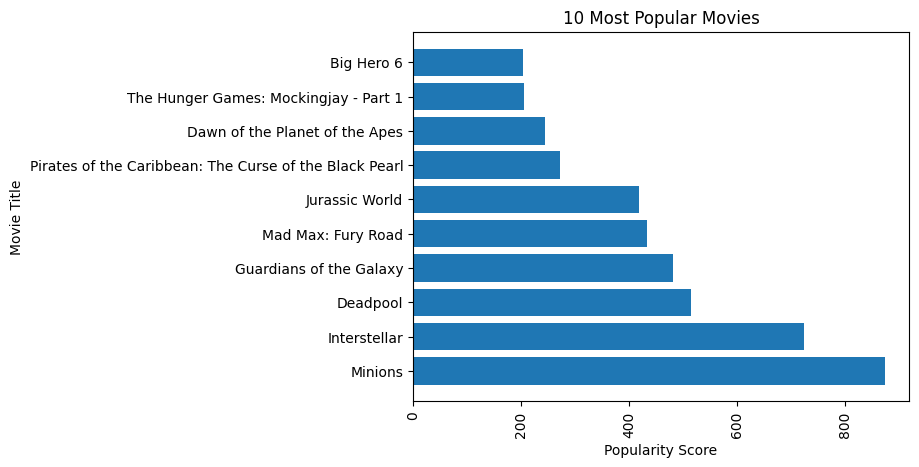

In [12]:
#create a barchart to show the most popular movies in dataset

popularity = top_movies.copy()
popularity = popularity[popularity['title'].notna()]
popularity = popularity.sort_values(by = 'popularity', ascending= False)
popularity
plt.barh(popularity['title'].head(10), popularity['popularity'].head(10))
plt.ylabel("Movie Title")
plt.xlabel("Popularity Score")
plt.title("10 Most Popular Movies")
plt.xticks(rotation = 90)

Text(0, 0.5, 'Movies Title')

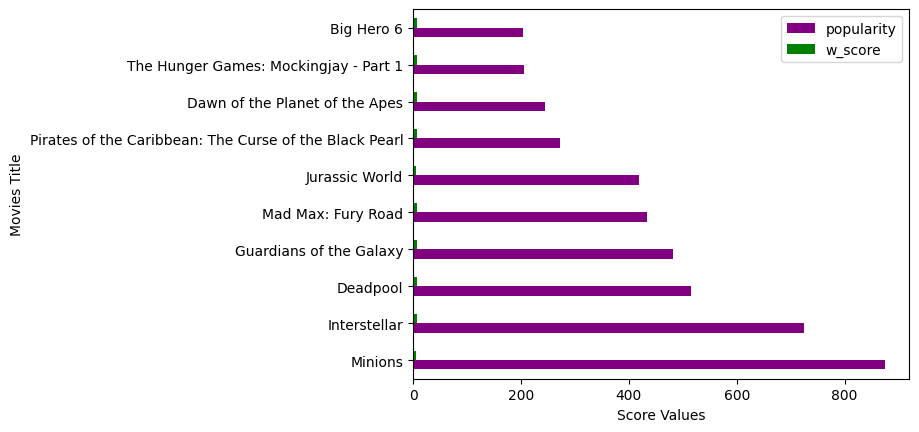

In [13]:
# above is just the popularity. Now I want to compare the weighted_rating side by side. There are two ways to do this:
# 1) sort the dataframe by popularity and plot the popularity and weighted ratings of those top 10, or 
# 2) sort the df by weighted_ratings and plot the popualarity and weighted ratings of those top 10. 
# First, let's sort based on popularity. We can do that simply by adding the 'weighted_rating' data into the above bar chart, which I have multiplied by 100 for scale value.

popularity.head(10).plot(x = "title", y = ["popularity", "w_score"], kind = "barh", color = ['purple', 'green'])
plt.xlabel("Score Values")
plt.ylabel("Movies Title")
#popularity.plot.barh(color={"popularity": "red", "w_score": "green"})



<Axes: ylabel='title'>

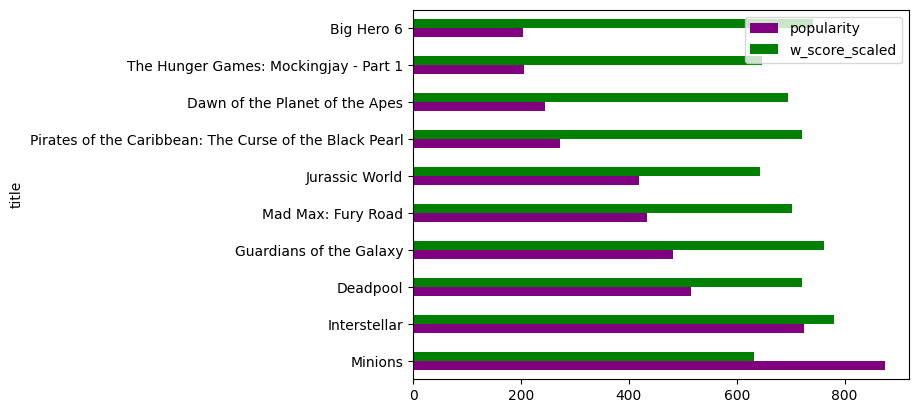

In [14]:
# Since the weighted score is so small compared to the popularity scores, we can multiply w_score by 100 for scale value.
popularity['w_score_scaled'] = popularity['w_score'] * 100
popularity.head(10).plot(x = "title", y = ["popularity", "w_score_scaled"], kind = "barh", color = ['purple', 'green'])

Text(0, 0.5, 'Movie Title')

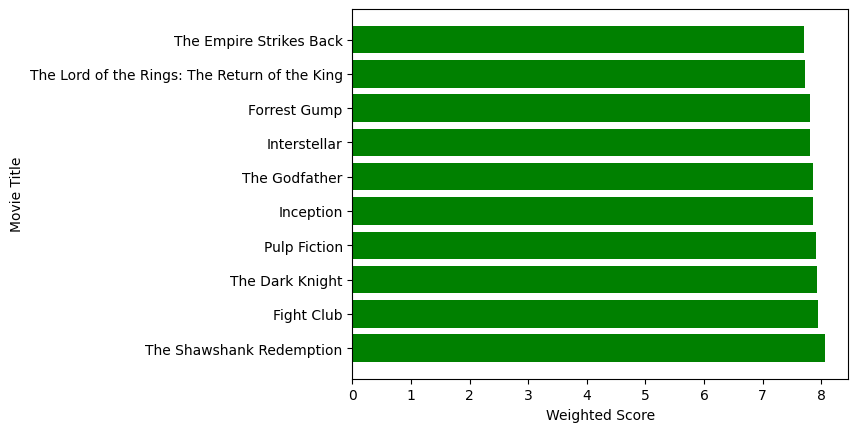

In [15]:
#Now let's do the second version and pick the top movies based on their weighted scores instead of their popularity.
weighted = top_movies.copy()
weighted = weighted.sort_values(by = 'w_score', ascending=False)
weighted
plt.barh(weighted['title'].head(10), weighted['w_score'].head(10), color = 'green')
plt.xlabel("Weighted Score")
plt.ylabel("Movie Title")


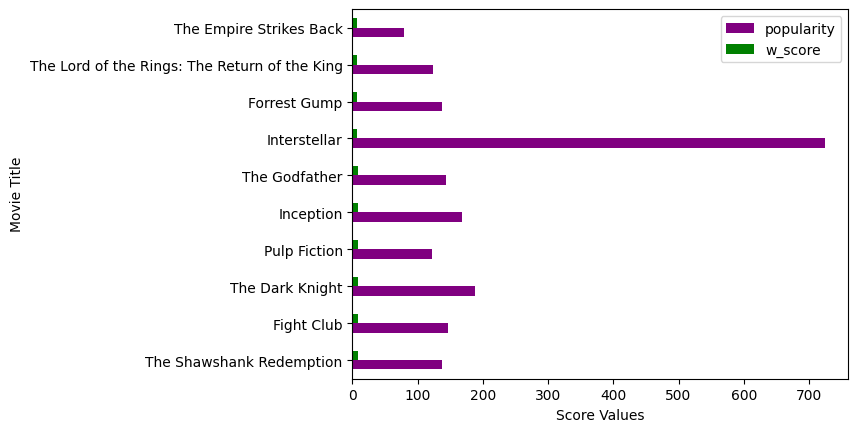

In [16]:
# Note that the list of ten movies has changed from when we filtered it to pick the ten movies with the highest popularity. Also, there is very little variation in w_scores of the movies above.
# Let's add popularity
weighted.head(10).plot(x = "title", y = ["popularity", "w_score"], kind = "barh", color = ['purple', 'green'])
plt.ylabel("Movie Title")
plt.xlabel("Score Values")
plt.legend(bbox_to_anchor=(1.0, 1.0))


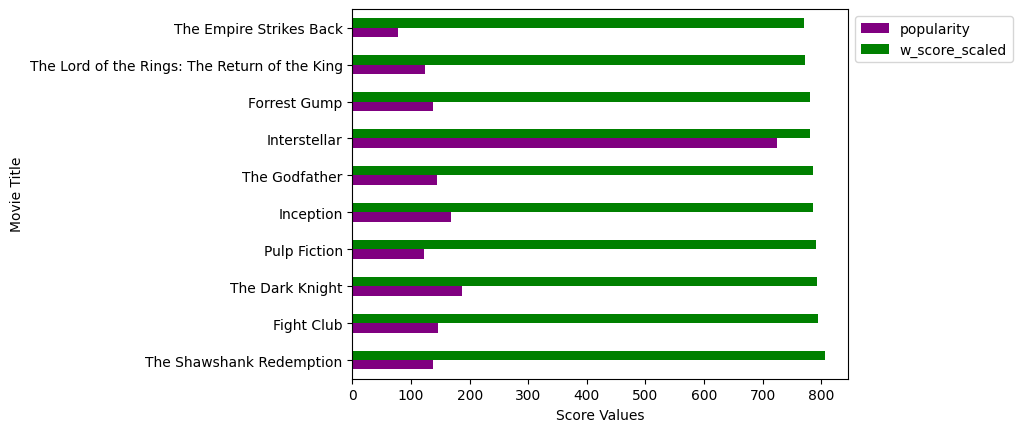

In [17]:
# Despite these ten movies having the highest weighted score in the entire dataset, Interstellar's popularity is around 4x that of the others. Let's try scaling w_score now.
weighted['w_score_scaled'] = popularity['w_score'] * 100
weighted.head(10).plot(x = "title", y = ["popularity", "w_score_scaled"], kind = "barh", color = ['purple', 'green'])
plt.ylabel("Movie Title")
plt.xlabel("Score Values")
plt.legend(bbox_to_anchor=(1.0, 1.0))

#it's a pretty big difference from the first comparison chart.

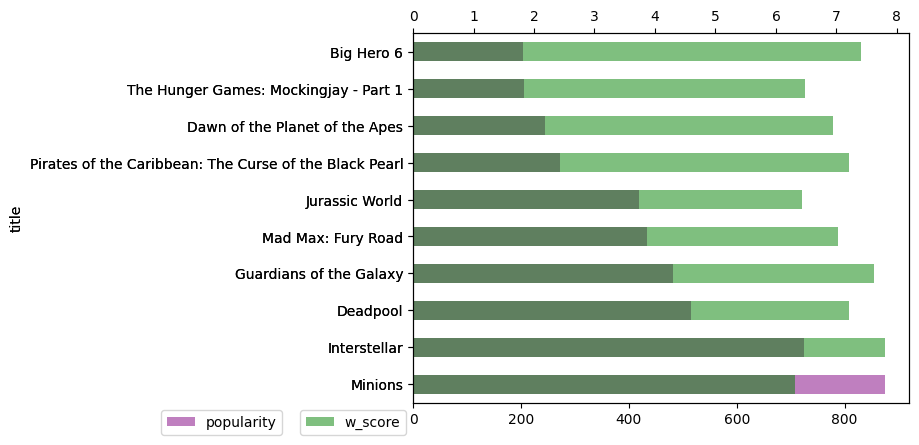

In [18]:
#another way to compare a movie's popularity and weighted scores is to overlay them on one another and using different axes for popularity/weighted scores. Let's do this with the top ten popular movies.
popularity2 = top_movies.copy()
popularity2 = popularity2[popularity2['title'].notna()]
popularity2 = popularity2.sort_values(by = 'popularity', ascending= False)
#popularity2

ax1 = popularity2.head(10).plot(x = "title", y = "popularity", kind = "barh", color = 'purple', alpha = 0.5)
plt.legend(bbox_to_anchor=(-.25, 0))
ax2 = ax1.twiny()
ax2 = popularity2.head(10).plot(x='title', y='w_score', kind='barh', color='green', ax=ax2, alpha=0.5)
plt.legend(bbox_to_anchor=(0, 0))

/var/folders/76/vgy6c2jd08j44rb590hxp8q00000gn/T/ipykernel_90144/3709048772.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1, 1))


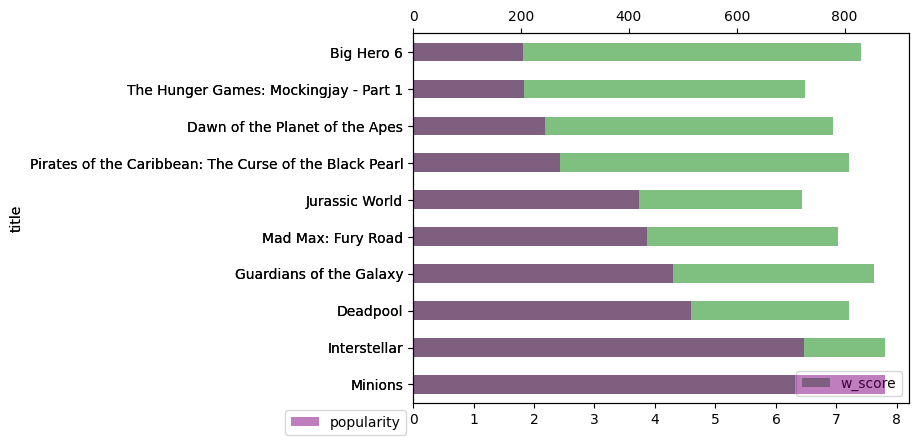

In [19]:
# Repeat but use the ten movies with the highest weighted scores.
weighted2 = top_movies.copy()
weighted2 = weighted2.sort_values(by = 'popularity', ascending= False)
weighted2

ax1 = weighted2.head(10).plot(x = "title", y = "w_score", kind = "barh", color = 'green', alpha = 0.5)
ax2 = ax1.twiny()
plt.legend(bbox_to_anchor=(1, 1))
ax2 = weighted2.head(10).plot(x='title', y='popularity', kind='barh', color='purple', ax=ax2, alpha =0.5)
plt.legend(bbox_to_anchor=(0, 0))


In [20]:
#And that concludes the demographic filtering!

In [21]:
#moving on to content-based filtering. we will do this in two different ways: 1) filtering based on plot and 2) filtering based on credits, genres, and keywords


In [22]:
#plot-based filtering
#produce tf-idf matrix
tfidf = TfidfVectorizer(stop_words='english')
movies['overview'] = movies['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(movies['overview'])
tfidf_matrix.shape

(4803, 20978)

In [ ]:
#20978 different words were used to describe the 4803 movies in our dataset

In [23]:
#calculating cosine similarity score
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [24]:
#reverse map the indices to their respective movie titles
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [25]:
# input: movie title, outputs top ten most similar movies
def get_recs(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]


In [27]:
get_recs('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [28]:
get_recs('Big Hero 6')

3917                        Phat Girlz
1008                           Chappie
170            The World Is Not Enough
4148                       Coffee Town
711                                RED
2238                          Bandslam
375                   Bicentennial Man
1343             Never Say Never Again
3434    A Home at the End of the World
1874                       August Rush
Name: title, dtype: object